# 3.1 MNIST

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [2]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


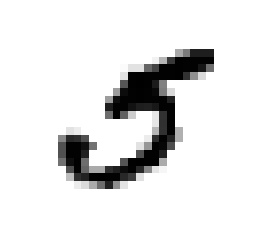

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
          interpolation = 'nearest')
plt.axis("off")
plt.show()

In [5]:
y[36000]

5.0

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# 3.2 Binary classifier

In [8]:
y_train_5 = (y_train == 5) # 5 is True, else False
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter = 5, random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

# 3.3 Performance measurement 

### 3.3.1 Cross Validation Score

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfold = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfold.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9657
0.96305
0.9659


In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = 'accuracy')

array([0.9657 , 0.96305, 0.9659 ])

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9112 , 0.90925, 0.9085 ])

### 3.3.2 Confusion Matrix

In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54008,   571],
       [ 1536,  3885]])

### 3.3.3 Precision and Recall

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8718581687612208

In [18]:
recall_score(y_train_5, y_train_pred)

0.7166574432761483

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7866761162296243

### 3.3.4 Precision/Recall Trade-off

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([34493.3213507])

In [23]:
threshold = 30000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([-339468.97698288, -828690.4158955 , -248536.28577547, ...,
       -409839.50451632,  126639.03517789, -256879.3902869 ])

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

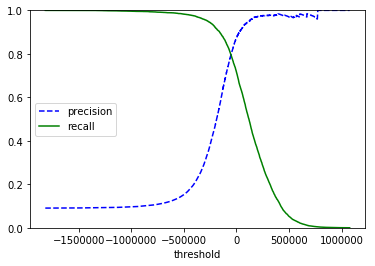

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.xlabel("threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

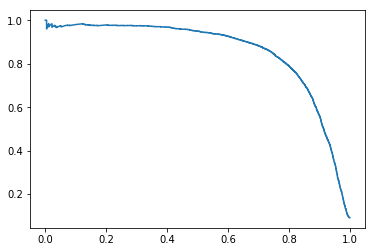

In [30]:
plt.plot(recalls[:-1], precisions[:-1])
plt.show()

In [31]:
y_train_pred_90 = (y_scores > 70000)
y_train_pred_90

array([False, False, False, ..., False,  True, False])

In [32]:
precision_score(y_train_5, y_train_pred_90)

0.9295652173913044

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.5915882678472607